### Визуализация сезонных трендов в кластерах

In [1]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = '/home/pavel/P/kaggle_data/expedia'

In [3]:
train_dtypes = {'site_name': np.int8, 'posa_continent': np.int8, 
                'user_location_country': np.int16, 'user_location_region': np.int16, 
                'user_location_city': np.int32, 'orig_destination_distance': np.float64, 
                'user_id': np.int32, 'is_mobile': np.bool, 'is_package': np.bool,
                'channel': np.int8, 'srch_adults_cnt': np.int8, 'srch_children_cnt': np.int8,
                'srch_rm_cnt': np.int8, 'srch_destination_id': np.int32, 
                'srch_destination_type_id': np.int8, 'is_booking': np.bool, 
                'cnt': np.int16, 'hotel_continent': np.int8, 'hotel_country': np.int16, 
                'hotel_market': np.int16, 'hotel_cluster': np.int8}

train = pd.read_csv(os.path.join(data_dir, 'train.csv'),
                    dtype=train_dtypes,
                    usecols=['date_time', 'hotel_cluster', 'is_booking', 'srch_ci', 'srch_co'])

### Посмотрим на самый популярный кластер - 91

In [4]:
cluster_91 = train[train['hotel_cluster']==91]

In [5]:
cluster_91['date'] = pd.to_datetime(cluster_91.date_time, errors='raise')
cluster_91 = cluster_91.drop(['date_time'], axis=1)

-c:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


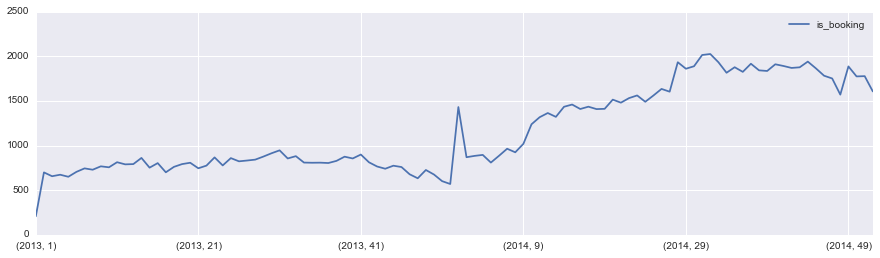

In [6]:
times = pd.DatetimeIndex(cluster_91.date)
grouped = cluster_91.groupby([times.year, times.week]).agg({'is_booking': 'sum'})
grouped.plot(figsize=(15, 4))

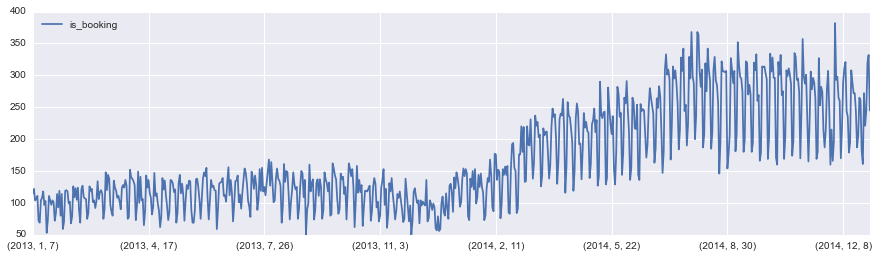

In [7]:
times = pd.DatetimeIndex(cluster_91.date)
grouped = cluster_91.groupby([times.year, times.month, times.day]).agg({'is_booking': 'sum'})
grouped.plot(figsize=(15, 4))

In [8]:
train.head()

,date_time,srch_ci,srch_co,is_booking,hotel_cluster
0,2014-08-11 07:46:59,2014-08-27,2014-08-31,False,1
1,2014-08-11 08:22:12,2014-08-29,2014-09-02,True,1
2,2014-08-11 08:24:33,2014-08-29,2014-09-02,False,1
3,2014-08-09 18:05:16,2014-11-23,2014-11-28,False,80
4,2014-08-09 18:08:18,2014-11-23,2014-11-28,False,21


### Загрузка кластера 91 (на основе srch_ci и srch_co)

In [46]:
rng = pd.date_range(start='1/1/2013', end='1/1/2016', freq='d')
ts = pd.Series(0, index=rng)

In [47]:
srch_ci = pd.DatetimeIndex(cluster_91.srch_ci)
srch_co = pd.DatetimeIndex(cluster_91.srch_co)

In [48]:
cluster_91['datetime_ci'] = pd.to_datetime(cluster_91.srch_ci, errors='raise')
cluster_91['datetime_co'] = pd.to_datetime(cluster_91.srch_co, errors='raise')

In [49]:
def fill_hotels(x):
    global ts
    ts[(ts.index <= x['datetime_co']) & (ts.index >= x['datetime_ci'])] += 1

In [50]:
t = cluster_91[cluster_91['is_booking']==True].apply(fill_hotels, axis=1)

In [51]:
ts_df = pd.DataFrame(ts)
ts_df.columns = ['events']

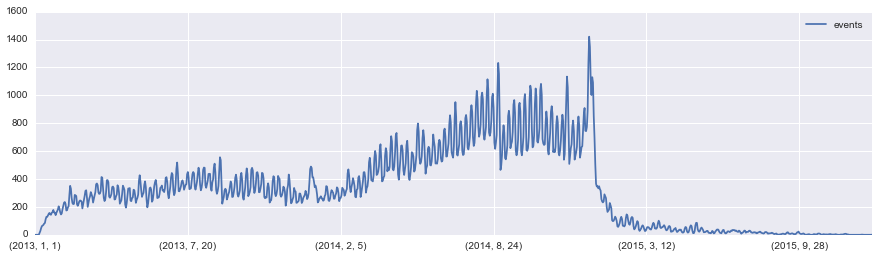

In [55]:
grouped = ts_df.groupby([ts_df.index.year, ts_df.index.month, ts_df.index.day]).agg({'events': 'sum'})
grouped.plot(figsize=(15, 4))